Q1:
What has the model learned about the correspondence between the item name and the classification? 
Answer--> 7up and sprite are classified as "lemon-line"
          Coke and pepsi are classified as "cola"

Problem:
Coke and pepsi could have different flavor/taste, however the model categorized them all together as "cola". The model is not well specialized.

Solution:
Retrain the model with more specific labels in order to seprate the items into a wider range of flavors.

In [4]:
pip install -r requirements.txt

  Using cached protobuf-3.20.0-cp37-cp37m-win_amd64.whl (905 kB)
  Using cached wrapt-1.14.1-cp37-cp37m-win_amd64.whl (35 kB)
     -------------------------------------- 126.5/126.5 kB 1.9 MB/s eta 0:00:00
     --------------------------------------- 23.2/23.2 MB 34.4 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
     ---------------------------------------- 1.5/1.5 MB 31.4 MB/s eta 0:00:00
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 46.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2023-01-19 23:25:00.359458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-01-19 23:25:00.359749: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-19 23:25:03.150376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2023-01-19 23:25:03.150519: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-19 23:25:03.153362: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-O07VI0E
2023-01-19 23:25:03.153856: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-O07VI0E


In [1]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
import re
import os
import seaborn as sns

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification, AdamW

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_csv('carbonated_soft_drinks.csv')

In [3]:
''' 
Creating corpus from dataset by removing tag, puncs, special chars.
'''


def corpus_maker():
        
        stop_words = ['bvc', 'ginger' ,'ale', 'cherry', 'soft', 'bottle', 'oz', 'can', 'diet', 'zero', 'beverage', 'soda', 
        'drink', 'bott', 'bottled', 'pepper', 'classic', 'sugar', 'dr', 'max']  
        raw_corpus = []
        for i in range(len(data)):

        #Remove punctuations
                text = re.sub('[^a-zA-Z]', ' ', data['item_name'][i])

        #Convert to lowercase
                text = text.lower()
        
        #remove tags
                text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # remove special characters and digits
                text=re.sub("(\\d|\\W)+"," ",text)

        ##Convert to list from string
                text = text.split()

                text = [word for word in text if not word in stop_words] 
                text = ' '.join(text)
                raw_corpus.append(text)
        return raw_corpus
raw_corpus = corpus_maker()

In [4]:
''' 
Find the empty corpus indexes and remove similar rows from dataset  
'''

def polish_data():

    empt_ind  = []
    j = 0
    while j < len(raw_corpus):
        if raw_corpus[j] == '':
            empt_ind.append(j)
        j += 1
            
    polish_data = data.drop(empt_ind)
    polish_data = polish_data.reset_index(drop=True)
    corpus = [k for k in raw_corpus if not k == '']
    return polish_data, corpus
p_data, corpus = polish_data()

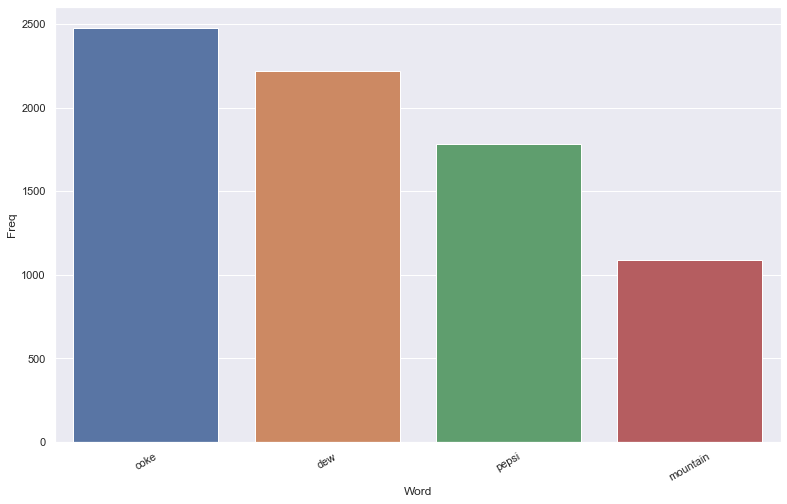

In [5]:
''' 
find the most frequent one word in dataset 
'''

def get_top_one_words():
        
        vec = CountVectorizer()
        bag_of_words = vec.fit_transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        #Convert most freq words to dataframe for plotting bar plot
        top_words = words_freq[:4]
        top_words_dict = {i[0]:i[1] for i in top_words}
        top_df = pd.DataFrame(top_words)
        top_df.columns=['Word', 'Freq']
        #Barplot of most freq words
        
        sns.set(rc={'figure.figsize':(13,8)})
        g = sns.barplot(x='Word', y='Freq', data=top_df)
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        return top_words_dict
top_words_dict = get_top_one_words()


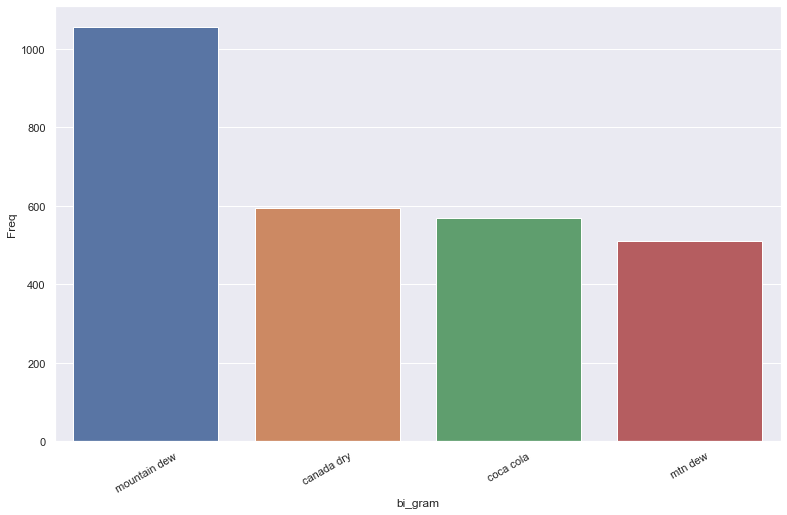

In [6]:
''' 
Find the most frequent two consecutive words in dataset 
'''

def get_top_two_words():
       
        vec = CountVectorizer(ngram_range=(2,2), max_features=2000)
        bag_of_words = vec.fit_transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        #Convert most freq words to dataframe for plotting bar plot
        top2_words = words_freq[:4]
        top2_words_dict = {i[0]:i[1] for i in top2_words}
        top2_df = pd.DataFrame(top2_words)
        top2_df.columns=['bi_gram', 'Freq']
        #Barplot of most freq words
        
        sns.set(rc={'figure.figsize':(13,8)})
        g = sns.barplot(x='bi_gram', y='Freq', data=top2_df)
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        return top2_words_dict
top2_words_dict = get_top_two_words()

In [7]:
''' 
Merge one most frequent and two most frequent word in case of overlap.
Assign each most frequent item to its related brand. 
This function returns a dictionary in which keys are the most frequent words and values are the brands.
'''

def brand_extracted():
    
    list_sep_2nd = [j for i in top2_words_dict.keys() for j in i.split()]
    merge_top = []
    for i in top_words_dict.keys():
        if i not in list_sep_2nd:
                merge_top.append(i)
    merge_top = merge_top + list(top2_words_dict.keys())
    brands = {}
    for item in merge_top:
        if 'coke' in item or 'coca' in item:
            brands[item] = 'coke'
        elif 'pepsi' in item or 'dew' in item:
            brands[item] = 'pepsi'
        else:
            brands[item] = item
    return brands
brands = brand_extracted()

In [8]:
''' 
This function uses NER(NAMED ENTITY RECOGNITION) and matching dictionary to extract the labels for each dataset record.  
'''

def ner_label_creater():
    
    nlp = en_core_web_sm.load()
    labels = {}
    for i,j in enumerate(corpus):
        for k in brands.keys():
            if k in j:
                labels[i] = brands[k]
                break
        if i not in labels.keys():
            nlp_created = nlp(j)
            for it in nlp_created.ents:
                if it.label_ == 'ORG':
                    tmp = str(it).split(' ')
                    if len(tmp) > 1:
                        for k in tmp:
                            if k in brands.keys():
                                labels[i] = brands[k]
                    else:
                        if str(it) in brands.keys():
                            labels[i] = brands[str(it)]
    return labels
labels = ner_label_creater()

In [9]:
''' 
This function added two columns to dataset namely brands and label and then save this csv file to directory. 
'''

def create_branded_data():

    possible_labels = list(set(labels.values()))
    label_dict = {}
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    selected_data = p_data.loc[p_data.index.isin(labels.keys())]
    selected_data = selected_data.reset_index(drop=True)
    selected_data['brands'] = labels.values()
    selected_data['label'] = selected_data.brands.replace(label_dict)
    if not os.path.exists('branded_data.csv'):
        selected_data.to_csv('branded_data.csv', index=False)
    return selected_data, label_dict
selected_data, label_dict = create_branded_data()

In [10]:
''' 
Create train, validation and test dataset and use bert tokenizer to tokenize each datasets 
'''

def data_prep_train():
   
    X = selected_data['item_name'].values
    y = selected_data['brands'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)
    selected_data['data_type'] = selected_data.apply(lambda x: 'train' if x['item_name'] in X_train else 
    ('val' if x['item_name'] in X_val else 'test'), axis=1)
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
    encoded_data_train = tokenizer.batch_encode_plus(
    selected_data[selected_data['data_type'] == 'train'].item_name.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt')

    encoded_data_val = tokenizer.batch_encode_plus(
    selected_data[selected_data['data_type'] == 'val'].item_name.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt')

    encoded_data_test = tokenizer.batch_encode_plus(
    selected_data[selected_data['data_type'] == 'test'].item_name.values, 
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    return_attention_mask=True, # Construct attn. masks
    pad_to_max_length=True, # Pad or truncate the sentence to `max_length`
    max_length=256, # Pad & truncate 
    return_tensors='pt')  # Return pytorch tensors

    input_ids_train = encoded_data_train['input_ids'] 
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(selected_data[selected_data['data_type'] == 'train'].label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(selected_data[selected_data['data_type'] == 'val'].label.values)

    input_ids_test = encoded_data_test['input_ids']
    attention_masks_test = encoded_data_test['attention_mask']
    labels_test = torch.tensor(selected_data[selected_data['data_type'] == 'test'].label.values)

    # Convert the datasets tensors
    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
    dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

    return dataset_train, dataset_val, dataset_test
dataset_train, dataset_val, dataset_test = data_prep_train()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\shahr\miniconda3\envs\vahe-project\lib\site-packages\transformers\tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [11]:
''' 
This function use train and validation dataset to retrain BERT with our custom dataset 
'''


BATCH_SIZE = 10
EPOCHS = 3
def train_model():

    dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train),  # Create the DataLoader
                              batch_size=BATCH_SIZE)

    dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=BATCH_SIZE)

    # Load BertForSequenceClassification, the pretrained BERT model with a single 
    # linear classification layer on top.

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab
                                                      num_labels=len(label_dict), # The number of output labels--3 for multiclass classification
                                                      output_attentions=False,  # Whether the model returns attentions weights
                                                      output_hidden_states=False)  # Whether the model returns all hidden-states
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    writer = SummaryWriter()
    optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
    step = 0
    val_step = 0

    # For each batch of training data...
    for epoch_num in range(EPOCHS):

        model.train()   # Put the model into training mode. Don't be mislead--the call to 
                        # train just changes the *mode*, it doesn't *perform* the training.
                        # dropout and batchnorm layers behave differently during training

        train_loss = 0   # Reset the total loss for this epoch
        

        for step_num, batch_data in enumerate(dataloader_train):
        

            if step_num % 20 == 0:  # Progress update every 20 batches due to lack of resources.

                step += 1

                batch = tuple(b.to(device) for b in batch_data)     # Unpack this training batch from our dataloader. 
                                                                    
                                                                    # As we unpack the batch, we'll also copy each tensor to the device using 
                                                                    # `to` method.
                                                                    #
                                                                    # `batch` contains three pytorch tensors:
                                                                    #   [0]: input ids 
                                                                    #   [1]: attention masks
                                                                    #   [2]: labels
                
                inputs = {'input_ids':      batch[0],
                        'attention_mask': batch[1],
                        'labels':         batch[2],
                        }       

                model.zero_grad()       # Always clear any previously calculated gradients before performing a
                                        # backward pass. PyTorch doesn't do this automatically because 
                                        # accumulating the gradients is "convenient while training RNNs"

                outputs = model(**inputs)       # Perform a forward pass (evaluate the model on this training batch).
                                                 
                                                # It returns different numbers of parameters depending on what arguments
                                                # arge given and what flags are set. For our useage here, it returns
                                                # the loss (because we provided labels) and the "logits"--the model
                                                # outputs prior to activation.
                batch_loss = outputs[0]
                train_loss += batch_loss.item()     # Accumulate the training loss over all of the batches so that we can
                                                    # calculate the average loss at the end. `loss` is a Tensor containing a
                                                    # single value; the `.item()` function just returns the Python value 
                                                    # from the tensor.



                writer.add_scalar("Training_Loss", train_loss / step, step - 1)
                
                # Perform a backward pass to calculate the gradients
                batch_loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem
                torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                optimizer.step()
                
                print('Epoch: ', epoch_num + 1)
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(dataloader_train), train_loss / step))

        if not os.path.exists('trained_bert_models'):
            os.makedirs('trained_bert_models')
        torch.save(model, f'trained_bert_models/finetuned_BERT_epoch_{epoch_num + 1}.pt')
        
        # Calculate the average loss over all of the batches.
        loss_train_avg = train_loss/step         
        print('Training loss at end of epoch {} is {}:'.format(epoch_num + 1, loss_train_avg))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        model.eval()    # Put the model in evaluation mode--the dropout layers behave differently
                        # during evaluation.


        # Tracking variables
        loss_val_total = 0
        predictions, true_vals = [], []
        
        # Evaluate data for one epoch
        for num_val_step, batch in enumerate(dataloader_validation):

            if num_val_step % 5 == 0:

                val_step += 1
            
                batch = tuple(b.to(device) for b in batch)
                
                inputs = {'input_ids':      batch[0],
                        'attention_mask': batch[1],
                        'labels':         batch[2],
                        }


                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        
                    outputs = model(**inputs)
                    
                loss = outputs[0]
                logits = outputs[1]

                # Accumulate the validation loss
                loss_val_total += loss.item()

                writer.add_scalar("Validation_Loss", loss_val_total / val_step, val_step - 1)

                print("\r" + "{0}/{1} validation loss: {2} ".format(num_val_step, len(dataloader_validation), loss_val_total / val_step))
                
                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = inputs['labels'].cpu().numpy()
                predictions.append(logits)
                true_vals.append(label_ids)
        
        # Calculate the average loss over all of the batches
        loss_val_avg = loss_val_total/val_step 
        print('avg loss afte {} epoch is {}'.format(epoch_num + 1, loss_val_avg))
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)
        ######### END OF EVALUATION
    
    writer.close()

    return model

model = train_model()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch:  1
0/478 loss: 1.0998873710632324 
Epoch:  1
20/478 loss: 1.143504023551941 
Epoch:  1
40/478 loss: 1.1449387868245442 
Epoch:  1
60/478 loss: 1.130900800228119 
Epoch:  1
80/478 loss: 1.1138249397277833 
Epoch:  1
100/478 loss: 1.0914943516254425 
Epoch:  1
120/478 loss: 1.0915969184466772 
Epoch:  1
140/478 loss: 1.0765775367617607 
Epoch:  1
160/478 loss: 1.0660556488566928 
Epoch:  1
180/478 loss: 1.0571697890758514 
Epoch:  1
200/478 loss: 1.0600426251238042 
Epoch:  1
220/478 loss: 1.043540398279826 
Epoch:  1
240/478 loss: 1.0394767476962163 
Epoch:  1
260/478 loss: 1.0166858179228646 
Epoch:  1
280/478 loss: 1.0343721071879068 
Epoch:  1
300/478 loss: 1.031073458492756 
Epoch:  1
320/478 loss: 1.024872148738188 
Epoch:  1
340/478 loss: 1.0112052261829376 
Epoch:  1
360/478 loss: 1.0085526704788208 
Epoch:  1
380/478 loss: 1.0068814694881438 
Epoch:  1
400/478 loss: 1.0068890651067097 
Epoch:  1
420/478 loss: 0.9925442717292092 
Epoch:  1
440/478 loss: 0.9878643854804661 

In [ ]:
!python -m tensorboard.main

In [ ]:
%load_ext tensorboard

In [44]:
%tensorboard --logdir runs 

Reusing TensorBoard on port 6006 (pid 6780), started 0:00:41 ago. (Use '!kill 6780' to kill it.)

In [47]:
'''  
Only uncomment this block if you trained already and want to load from saved model.
'''


# BATCH_SIZE = 10
# EPOCHS = 3

# model = BertForSequenceClassification.from_pretrained("bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab
#                                                       num_labels=3, # The number of output labels--3 for multiclass classification
#                                                       output_attentions=False,  # Whether the model returns attentions weights
#                                                       output_hidden_states=False)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model = torch.load('trained_bert_models\\finetuned_BERT_epoch_3.pt')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [51]:
''' 
This is testing the model with test dataset. The process is similar to the validation part of training function. 
For more info regarding each step, please check the notes of training function.
This function returns the predictions with size of (len(test_dataset), number of classes) and test true labels with size of (len(test_dataset),)
The argmax of each prediction return the predicted label.
'''

def model_eval():

    dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=BATCH_SIZE)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    
    loss_test_total = 0
    predictions, true_tests = [], []

    for test_step_num, batch in enumerate(dataloader_test):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                    }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        test_loss = outputs[0]
        logits = outputs[1]
        loss_test_total += test_loss.item()
        
        

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_tests.append(label_ids)

        

    loss_test_avg = loss_test_total/len(dataloader_test) 

    predictions = np.concatenate(predictions, axis=0)
    true_tests = np.concatenate(true_tests, axis=0)


    return predictions, true_tests

predictions, true_tests = model_eval()

In [52]:
''' 
Predictions with size of (len(test_dataset), number of classes) and test true labels with size of (len(test_dataset),)
The argmax of each prediction return the predicted label.
accuracy_per_class function claculate the number of prediction over number of ground truth of each class
Classification report present (precision, recall, f1-score) for each class which is represented by row index.  
'''

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

accuracy_per_class(predictions, true_tests)
print('\n')
print(classification_report(true_tests.flatten(), np.argmax(predictions, axis=1).flatten()))

Class: coke
Accuracy: 513/515

Class: pepsi
Accuracy: 533/533

Class: canada dry
Accuracy: 102/115



              precision    recall  f1-score   support

           0       0.98      1.00      0.99       515
           1       1.00      1.00      1.00       533
           2       1.00      0.89      0.94       115

    accuracy                           0.99      1163
   macro avg       0.99      0.96      0.97      1163
weighted avg       0.99      0.99      0.99      1163

